###  **Overview**

*   Why using colab?
*   loading data and check data
*   visulize data using ***matplotlib***
*   Perceptron Algorithm with linearly seperable data
*   Perceptron Algorithm with Non-linearly separable data
*   Numpy


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 473612165576322767, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11061655134915437024
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13751582624282104875
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11146783616
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2392819725012550097
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# **Loading Data**


###  **Clone dataset from github**

*   Copy data from git:  ***! git clone "github repo"***
*   "!" implies that the line is not a python code but command line script
*   List directory contents:  ***ls***
*   If you want to look subdirectories recursively:  ***ls -R***
*   For more commands, check https://cheatography.com/davechild/cheat-sheets/linux-command-line/

In [ ]:
! rm -rf csce_421_633_s20/
! git clone https://github.com/prafulla77/csce_421_633_s20.git

Cloning into 'csce_421_633_s20'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 34 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
! ls -R

.:
base_model_3.slurm  csce_421_633_s20  sample_data

./csce_421_633_s20:
'AD 47537198 07-19.pdf'     hw1_question1_train.csv   README.md
 cats-dogs-knn.txt	    hw1_question2_dev.csv     table.pdf
 cats-dogs-perceptron.txt   hw1_question2_test.csv

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
! pwd
! ls

/content
base_model_3.slurm  csce_421_633_s20  sample_data




### **Check data file format**

*   Check data format by printing few lines: **head -number_of_lines FileName**




In [ ]:
! head -15 csce_421_633_s20/cats-dogs-perceptron.txt
! cat csce_421_633_s20/cats-dogs-knn.txt   # Don't use this for larger files


Height	Weight	Label
27	50	Dog
23	44	Dog
25	85	Dog
27	75	Dog
15	20	Dog
23	55	Dog
16	23	Dog
25	110	Dog
27	45	Dog
23	90	Dog
13	18	Cat
8	13	Cat
8.2	14	Cat
6	10	Cat
Height	Weight	Label
10	7	Dog
27	50	Dog
23	44	Dog
25	85	Dog
27	75	Dog
15	20	Dog
23	55	Dog
11	14	Dog
16	23	Dog
25	110	Dog
27	45	Dog
23	90	Dog
13	18	Cat
8	16	Cat
8.2	14	Cat
6	10	Cat
7	11	Cat
9.5	19	Cat
12	14	Cat
10	9	Cat
7	7	Cat
7.5	8	Cat
8	11	Cat
15	25	Cat
5	19	Cat
10	22	Cat


In [ ]:
! head -5 sample_data/california_housing_test.csv

"longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"
-122.050000,37.370000,27.000000,3885.000000,661.000000,1537.000000,606.000000,6.608500,344700.000000
-118.300000,34.260000,43.000000,1510.000000,310.000000,809.000000,277.000000,3.599000,176500.000000
-117.810000,33.780000,27.000000,3589.000000,507.000000,1484.000000,495.000000,5.793400,270500.000000
-118.360000,33.820000,28.000000,67.000000,15.000000,49.000000,11.000000,6.135900,330000.000000


### **Parse data file**

*   Recommended to define ***Class*** to group data and methods (makes your code easy to update and understand)
*   Define a class for datapoint

In [ ]:
import numpy as np


class DataPoint(object):

  def __init__(self, feats):
    """
    Return a Datapoint object whose attributes are given by "feats"
    """
    self.height = feats['height']
    self.weight = feats['weight']
    self.label = feats['label']

  def feature_vector(self):
    """
    Return feature vector as a numpy array
    """
    return np.array([self.height, self.weight])

  def feature_vector_with_bias(self):
    """
    Return features with 1 appended at the end
    We 'absorb' bias (b) into the feature vector w by adding one additional constant dimension
    y = wx + b becomes y = w'x' where x' = [x; 1] and w' = [w; b] 
    """
    return np.array([self.height, self.weight, 1.])

  def __str__(self):
    """
    print(object) uses this method
    Define it in the way you want to see the object (e.g. Height:27.0, Weight:50.0, Label:1)
    """
    return "Height:{}, Weight:{}, Label:{}".format(self.height, self.weight, self.label)


*   Parse the data file

In [34]:
def parse_dataset(filename):
  data_file = open(filename, 'r')  # Open File "to read"
  dataset = []  # List to hold Datapoint objects
  label_map = {'Cat': -1, 'Dog': 1}  # Since we will be using "Perceptron", we need to define labels as -1/1. 

  for index, line in enumerate(data_file): # index is the data index, line is the data
    if index == 0:  # First line: "Height	Weight	Label" describes the datapoint, it's not an actual datapoint, 
      continue  # do nothing, it will skip all the following lines 
    height, weight, label = line.strip().split('\t')  # strip() removes '\n', and split('\t') splits the line at tabs
    dataset.append(DataPoint({'height':float(height), 'weight':float(weight), 'label':label_map[label]}))  # Create DataPoint object for the given data

  print("Total Number of Data Points: {0}".format(len(dataset)))
  print("Examples: 1 - {0} , 2 - {1}".format(dataset[0], dataset[-1]))
  return dataset


dataset = parse_dataset('csce_421_633_s20/cats-dogs-perceptron.txt')  # Returns the list of datapoints

Total Number of Data Points: 24
Examples: 1 - Height:27.0, Weight:50.0, Label:1 , 2 - Height:10.0, Weight:22.0, Label:-1


# **Visualizing Dataset**

*   We can use ***matplotlib.pyplot*** to build interactive plots
*   Check https://matplotlib.org/users/pyplot_tutorial.html to see introductory examples for different types of plots.

### ***Examples***

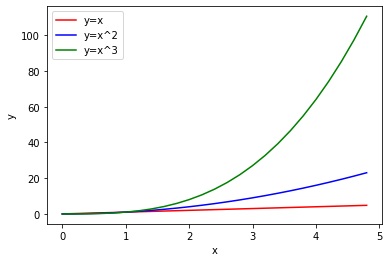

In [ ]:
import matplotlib.pyplot as plot


t = np.arange(0., 5., 0.2)  # [0.0, 0.2, 0.4, ......, 4.8]

plot.plot(t, t, 'r', label="y=x")  # red (y=x),
plot.plot(t, t**2, 'b', label="y=x^2")  # blue (y=x^2),
plot.plot(t, t**3, 'g', label="y=x^3")  # green (y=x^3),
plot.xlabel("x")  # label: x axis
plot.ylabel("y")  # label: y axis
plot.legend()  # to show legend
plot.show()

### ***Scatter Plot: Datapoints***

*   Shows the data as a collection of points
*   Position of a point depends on its attributes' values, where each value is a position on one axis.

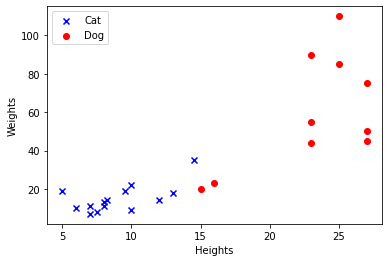

In [ ]:

def plot_data(dataset):
  cat_heights = [data.height for data in dataset if data.label == -1]  # List: heights of cats 
  cat_weights = [data.weight for data in dataset if data.label == -1]  # List: weights of cats

  dog_heights = [data.height for data in dataset if data.label == 1]  # List: heights of dogs 
  dog_weights = [data.weight for data in dataset if data.label == 1]  # List: weights of dogs 

  plot.scatter(cat_heights, cat_weights, c='b', marker='x', label='Cat')  # put points corresponding to cats, b: blue colored, x: marked with 'x'
  plot.scatter(dog_heights, dog_weights, c='r', marker='o', label='Dog')  # put points corresponding to dogs, r: red colored, o: marked with 'o'

  plot.xlabel("Heights")
  plot.ylabel("Weights")
  plot.legend()
  plot.show()


plot_data(dataset)

# **Perceptron Algorithm**

***Assumes:*** Datapoints are linearly separable


### ***Pseudo-code***


```
# Perceptron Algorithm Pseudo Code
1. W = 0
2. while True:
3.   m = 0
4.   for (x,y) in D
5.    if y.(W'x) <= 0
6.      W <- W + y.x
7.      m <- m+1
8.  if m == 0
9.    break
```

### ***Perceptron: Code***
*    Just like DataPoints, we will define a ***Perceptron*** class.

In [ ]:
class Perceptron(object):

  def __init__(self, feature_dim=3):
    """
    Return a Perceptron classifier object with parameters initialized to 0 vector.
    """
    self.w = np.zeros(feature_dim)  # Intialize: parameters as zero vector

  def train(self, datapoints, max_iterations=20000):
    """
    Train the Perceptron classifier object until convergence or max_iterations.
    Return: A list containing losses (=number of misclassified datapoints) for each iteration
    """
    losses = []  # Store loss at each iteration 
    iteration = 0  # Initialize: iteration = 0
    while True:
      m = 0  # m: store number of mis-classified datapoints
      for datapoint in datapoints:  # iterate through each data point
        if datapoint.label*self.w.dot(datapoint.feature_vector_with_bias()) <= 0:  # if data point is misclassified
          self.w = self.w+datapoint.label*datapoint.feature_vector_with_bias()  # update the weight
          m = m+1  # increment m by 1
      losses.append(m)  # append 
      

      
      if m == 0:
        # All points were correctly classified
        print('Finished training in {0} Iterations'.format(iteration))
        break
      if iteration > max_iterations:
        # m is not 0, some points are still miss-classified
        print("Couldn't find solution after {0} iterations".format(max_iterations))
        break
      iteration = iteration + 1  # after going through all the datapoints, icrement the iteration by 1
      
    return losses  # return losses

  def predict(self, datapoints):
    """
    Return: Predictions on the new datapoints
    """
    return datapoints.dot(self.w)

Finished training in 568 Iterations
--------------------------------
Plotting final decision boundary


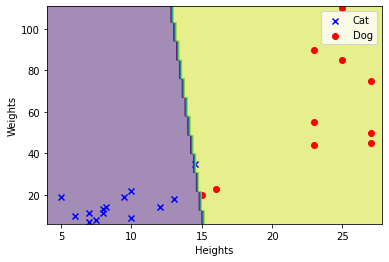

Plotting Losses


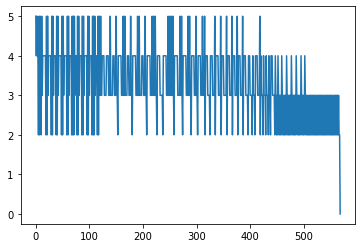

In [ ]:
def plot_current(model, dataset, kNN=False):

  cat_heights = np.array([data.height for data in dataset if data.label == -1])  # Numpy array: heights of cats 
  cat_weights = np.array([data.weight for data in dataset if data.label == -1])  # Numpy array: weights of cats

  dog_heights = np.array([data.height for data in dataset if data.label == 1])  # Numpy array: heights of dogs 
  dog_weights = np.array([data.weight for data in dataset if data.label == 1])  # Numpy array: weights of dogs 

  x_min, x_max = min(cat_heights.min(), dog_heights.min())-1., max(cat_heights.max(), dog_heights.max())+1.  # Find minimum and maximum values for cat's height and weight
  y_min, y_max = min(cat_weights.min(), dog_weights.min())-1., max(cat_weights.max(), dog_weights.max())+1.  # Find minimum and maximum values for dog's height and weight

  """
  np.meshgrid(x1, x2): Return coordinate matrices from coordinate vectors
  Example: x1 = [1,2,3,4], x2=[1,2,3,4]
           output: [[1, 2, 3, 4],    and    [[1, 1, 1, 1],
                    [1, 2, 3, 4],            [2, 2, 2, 2],
                    [1, 2, 3, 4],            [3, 3, 3, 3],
                    [1, 2, 3, 4]]            [4, 4, 4, 4]]
          
  You can see this as  [[(1,1), (2,1), (3,1), (4,1)],
                        [(1,2), (2,2), (3,2), (4,2)],
                        [(1,3), (2,3), (3,3), (4,3)],
                        [(1,4), (2,4), (3,4), (4,4)]]
  """
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))

  """
  xx.reshape(-1,1) transforms this to a column vector
  Example: x1 = [[1,2], [3,4]]
           out = [[1],[2],[3],[4]]
  """

  # Concatenate the xx and yy vector to obtain 2-d features
  if kNN:
    Z = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)  # kNN doesn't require bias term
  else:
    Z = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), np.ones(xx.reshape(-1, 1).shape)), axis=1)  # append 1 for the bias term
  Z = model.predict(Z)  # Use model to predict on datapoints Z
  Z = Z > 0  # Find their class, returns 1 if prediction > 0 
  Z = Z.reshape(xx.shape)  # transform this back to the shape of xx (2d matrix) 

  plot.contourf(xx, yy, Z, alpha=0.5)  # draw filled contours
  plot.contour(xx, yy, Z, linewidths=0.7)  # Plot contour line aka decision boundary 
  # put points corresponding to cats, b: blue colored, x: marked with 'x'
  plot.scatter(cat_heights, cat_weights, c='b', marker='x', label='Cat') 
  # put points corresponding to dogs, r: red colored, o: marked with 'o'
  plot.scatter(dog_heights, dog_weights, c='r', marker='o', label='Dog')  

  plot.xlabel("Heights")
  plot.ylabel("Weights")
  plot.legend()

  plot.show()

perceptron_classifier = Perceptron(3)  # Create a Perceptron classifier object
losses = perceptron_classifier.train(dataset, 20000)  # Train for 20000 epochs

print("--------------------------------")
print("Plotting final decision boundary")
plot_current(perceptron_classifier, dataset)  # Plot decision boundary

print("Plotting Losses")
plot.plot(losses)  # Plot losses
plot.show()

Plotting sampled Losses


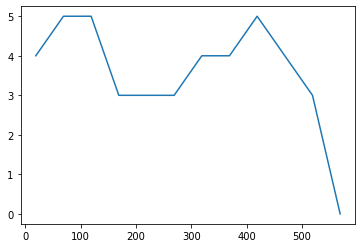

In [ ]:
"""
Plotting sampled losses:
Starting from the end, sample every 1000th loss term
This allows us to see the loss in last iteration, 
which should be 0 if the model has converged
"""
sampled_loss, iteration = [], []
# losses[::-1] traverse list in reverse order
# enumerate(list) allows us to loop over the list with an automatic counter
for index, loss in enumerate(losses[::-1]):
  if index%50 == 0:
    sampled_loss.append(loss)
    iteration.append(len(losses)-index)

print("Plotting sampled Losses")
plot.plot(iteration, sampled_loss)  # Plot losses
plot.show()

# **Non-linearly separable data**

*    Perceptron assumes that data points are linearly separable
*    If data points are not linearly separable, perceptron will run for ever but will never stop/ converge.

Total Number of Data Points: 26
Examples: 1 - Height:10.0, Weight:7.0, Label:1 , 2 - Height:10.0, Weight:22.0, Label:-1


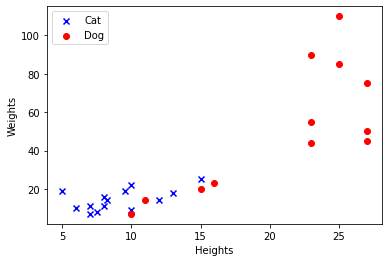

Couldn't find solution after 20000 iterations
--------------------------------
Plotting final decision boundary


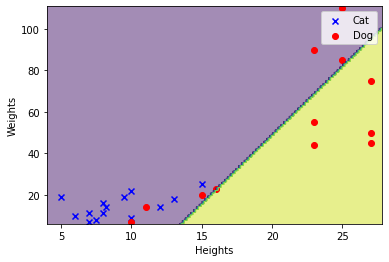

Plotting Losses


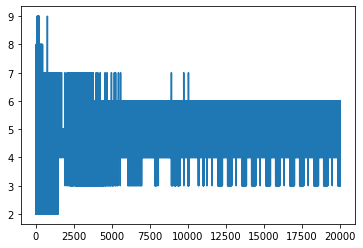

In [ ]:
dataset = parse_dataset('csce_421_633_s20/cats-dogs-knn.txt') 
plot_data(dataset)

perceptron_classifier = Perceptron(3)
losses = perceptron_classifier.train(dataset, 20000)

print("--------------------------------")
print("Plotting final decision boundary")
plot_current(perceptron_classifier, dataset)

print("Plotting Losses")
plot.plot(losses)
plot.show()

# **Numpy**

*    Package for vector and matrix operations
*    Extremely optimized for speed (efficient memory representation and low-level machine instructions)
*    Ndarray: Most important structure
*    Refer to the documentations (https://docs.scipy.org/doc/numpy-1.17.0/reference/) for further details

In [ ]:
import numpy as np
a = np.random.rand(5,4)  # Create matrix of shape (5,4) filled with rando values
print(a)
b = np.ones(4)   # Create vectors of 1s
print(np.zeros((4,2)))
print(b)
print(a.shape, b.shape)  # Check shape of arrays

[[0.69324599 0.43238992 0.17031796 0.60862076]
 [0.79455821 0.94129397 0.82442897 0.33305466]
 [0.07709784 0.29457611 0.55409451 0.50855   ]
 [0.74035761 0.69535769 0.46942398 0.07127182]
 [0.08852536 0.30325955 0.1675225  0.02733347]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[1. 1. 1. 1.]
(5, 4) (4,)


In [ ]:
print(a+b)  # Broadcasting: If number of dimension doesn't match

[[1.69324599 1.43238992 1.17031796 1.60862076]
 [1.79455821 1.94129397 1.82442897 1.33305466]
 [1.07709784 1.29457611 1.55409451 1.50855   ]
 [1.74035761 1.69535769 1.46942398 1.07127182]
 [1.08852536 1.30325955 1.1675225  1.02733347]]


In [ ]:
print(np.matmul(a,b)) # Matrix multiplication

[1.90457464 2.8933358  1.43431846 1.97641111 0.58664089]


In [ ]:
c = np.random.rand(4,)
print(c)
print (b.dot(c), c.sum(), c.max(), c.min())  # Some useful functions

[0.87783644 0.61659705 0.65550098 0.35310469]
2.5030391688603437 2.5030391688603437 0.8778364440173193 0.35310469189148763


In [ ]:
print(a.max(axis=0))  # Maximum along an axis

1


In [ ]:
"""
Compare speed of execution
"""

a = [1]*10000000

def dot_p(a, b):
  #  return dot products
  return sum([a[i]*b[i] for i in range(len(a))])

import time
st = time.time()  # get current time
print(dot_p(a, a))  # do dot product using self-defined method 
print("Time taken using self-defined method: {0}".format(time.time()-st))  # print time taken

a = np.array(a)
st = time.time()
print(a.dot(a))
print("Time taken using numpy-based method: {0}".format(time.time()-st))

10000000
Time taken using self-defined method: 1.0126979351043701
10000000
Time taken using numpy-based method: 0.011801958084106445


# **Acknowledgements**

*    This tutorial is prepared based on materials from  Prafulla Kumar Choubey (Texas A&M)

